<a href="https://colab.research.google.com/github/gabrivoy/equipmentfailure-analysis/blob/main/finalreport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset analysis report

Dataset analysis report built as part of the Hard Skill Test for a position as Data Scientist (PT-BR).

Developed by Gabriel Ribeiro Gomes, [@gabrivoy](https://github.com/gabrivoy). *ribeiroggabriel@gmail.com*.

---

## Case analysis.

To enable the operations of an FPSO, we use sensors to make sure the equipment does not fail. These sensors measure different parameters of the equipment in different setups configurations (preset 1 and preset 2) over time. This report aims to investigate one piece of equipment in different time cycles to understand what characteristics and parameters of the sensors might indicate that the equipment is (on the verge of) failing. To solve this problem, some specific questions may guide the analysis:

1.   Calculate how many times the equipment has failed.
2.   Categorize  equipment failures by setups configurations.
3.   Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).
4.   Create a model using the technique you think is most appropriate and measure its performance.
5.   Analyze variable importance.

---

## Imports


In [65]:
# Main libraries imports
# Connects to google drive to access file 'dataset.xlsx'

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
# Defining parameters for seaborn graphs

sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_style("ticks")
sns.set_context('notebook')

## Exploratory analysis

Database import and analysis of key points using the functions '*head( )*' and '*info( )*'


In [67]:
# pd.read_excel for accessing the dataset
# data variable will be our dataframe structure for analysis

dataset = pd.read_excel(r"/content/drive/MyDrive/Colab/Shape/dataset.xlsx")
data = pd.DataFrame(dataset)

In [68]:
# first dataset visualization using data.head()

data.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [69]:
# key points of the dataset with data.info()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


This first step analysis can give us some basic info about the database:

- 800 rows.
- 10 collumns.
- No missing values.
- 1 collumn with boolean values.
- 3 collumns with Integers.
- 6 collumns with floats.

And other statistical information that we can obtain using the '*describe( )*' method.

---

Also, we can make some assumptions about the dataset now:

- We're analyzing one generic engineering equipment, as said before. 
  - Engineering equipment is designed to last, so we can argue that we probably are working with an unbalaced sample on our dataset.
  - Data usually comes cross-sectional time-series format.

- The economy of implying things about equipment in operation:
  - False positives: costs time and money to board a vendor or move some technical help on board to check. 
  - True positives: cost time and money to board a vendor or technical help on board, and the tools needed to perform the maintenance because the equipment will be truly failing.
  - False negatives: costs more money and gives us less time to react because is a failure that we weren't expecting. Needs repair faster, so usually costs a lot more.
  - True negatives: costs 0.

---

In [70]:
# generating basic statistics with data.describe()

data.describe()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,1.988750,4.551250,69.263494,78.997945,73.860275,72.786878,71.866211,68.223449
std,231.0844,0.805875,2.293239,25.536252,32.501834,31.229631,32.739745,27.844616,29.138702
min,1.0000,1.000000,1.000000,2.089354,3.480279,3.846343,10.057744,18.784169,4.380101
25%,200.7500,1.000000,3.000000,51.040134,55.508564,50.752461,48.523982,50.787638,45.861762
50%,400.5000,2.000000,5.000000,65.906716,75.014848,69.394953,65.504770,69.319237,65.664252
75%,600.2500,3.000000,7.000000,80.527220,99.302530,90.195059,94.075572,88.891205,90.097457
max,800.0000,3.000000,8.000000,255.607829,189.995681,230.861142,193.569947,230.951134,178.090303


We can boxplot the dataset to have a look at how many outliers we have in the data

---

Text(0, 0.5, 'Values')

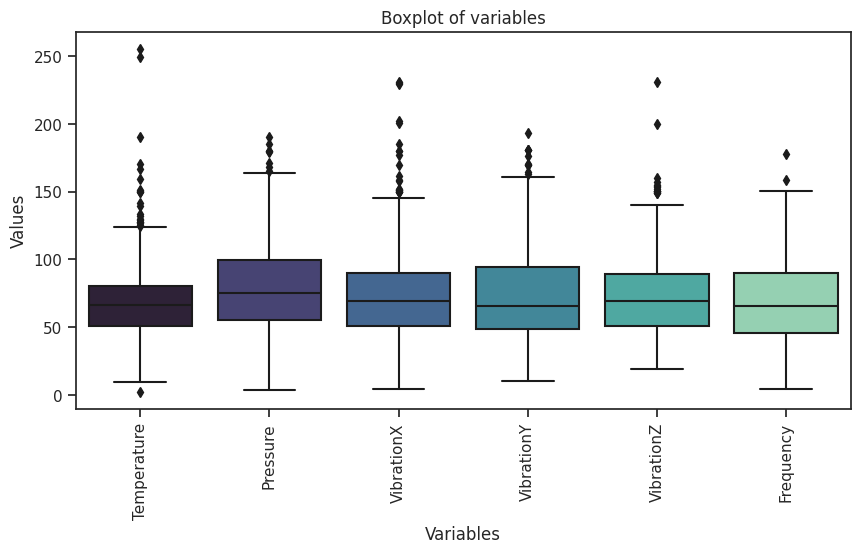

In [71]:
sns.boxplot(data = data[['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']], palette='mako')

plt.xticks(rotation=90)
plt.title('Boxplot of variables')
plt.xlabel('Variables')
plt.ylabel('Values')

The quantity of outliers per collumn is:


In [72]:
# outl variable for analyzing outliers count
outl = data[['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']].copy()

# quartiles
q1 = outl.quantile(0.25)
q3 = outl.quantile(0.75)
iqr = q3 - q1

((outl < (q1 - 1.5 * iqr)) | (outl > (q3 + 1.5 * iqr))).sum()

Temperature    22
Pressure        8
VibrationX     20
VibrationY     10
VibrationZ     14
Frequency       2
dtype: int64

In [73]:
# total number of outliers

((outl < (q1 - 1.5 * iqr)) | (outl > (q3 + 1.5 * iqr))).sum().sum()

76

# Computation of the Fail column

To better understand the dataset, one should analyze the implications the data has. In simpler terms, what is the expected result according to the input of the necessary data for a model to be able to analyze failure of equipments.

We can see that in the Fail column we have the equipment's behavior for each cycle of work (assuming each cycle lasted a fixed **T** time and this time has not varied between cycles). As already said, it is expected that a equipment in a FPSO is not going to fail routinely because, after all, investments are made so it doesn't fail.

The 'Fail' column is a boolean column, so, it only presents two values and their interpretation:

- False (0): The equipment **has not** failed.
- True (1): The equipment **has** failed.

---

In [74]:
data.Fail.value_counts()

False    734
True      66
Name: Fail, dtype: int64

In [75]:
true_count = data.Fail.sum()
false_count = len(data) - true_count

percent_false = (false_count/len(data))*100
percent_true = 100 - percent_false
print(percent_false, percent_true)

91.75 8.25


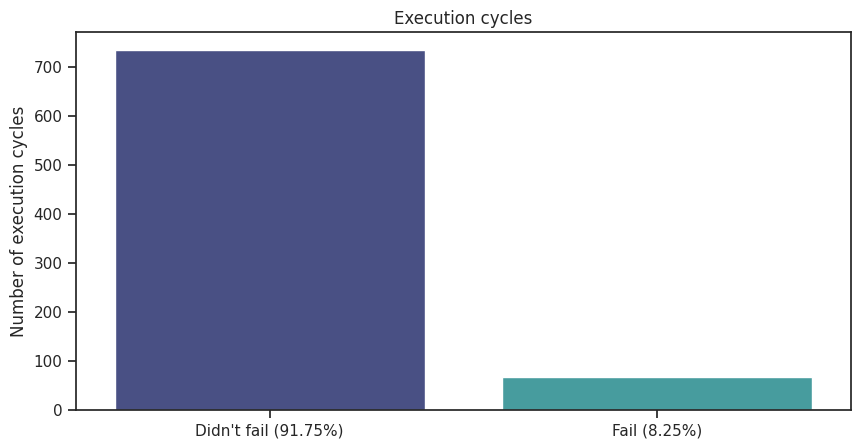

In [76]:
sns.barplot(x = ['Didn\'t fail (' + str(percent_false) + '%)','Fail (' + str(percent_true) + '%)'], y = list(data.Fail.value_counts()), palette='mako')

plt.title('Execution cycles')
plt.ylabel('Number of execution cycles')
plt.show()

So we can actually confirm that the data is unbalanced. We have a much bigger proportion of data where the equipment does not fail. For a statistical analysis, we can see that, from the whole dataset, we have:

- 800 executions
- 734 executions that didn't fail, which represents 91.75% of the sample.
- 66 executions that did fail, which represents 8.25% of the sample.

---

We can also analyze the failures through time cycles. Considering each cycle as **N+1** and necessarily a successor of **N**, we can look at the failures in timely manner.

---

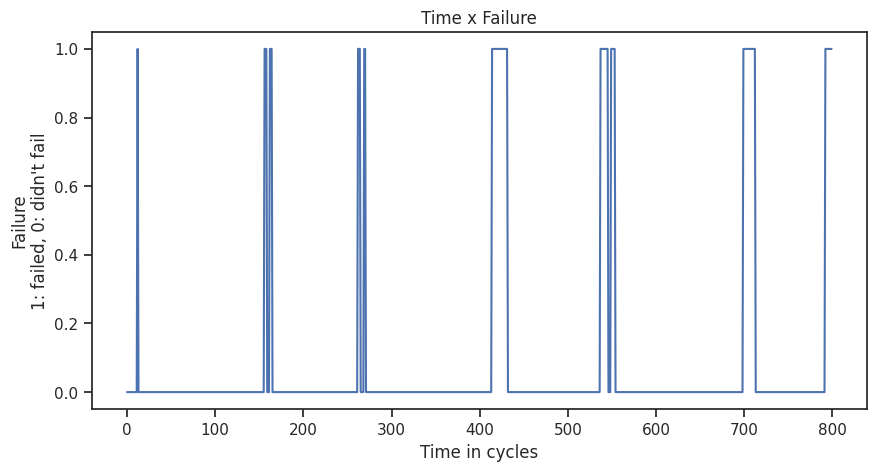

In [77]:
plt.plot(data.Fail)
plt.title('Time x Failure')
plt.xlabel('Time in cycles')
plt.rcParams["figure.figsize"] = [10, 5]
plt.ylabel('Failure\n1: failed, 0: didn\'t fail')
plt.show()

As we can see, failures happen in temporal blocks and not isolated, apparently. We can check for occurrences of failures at the following intervals:

* [0, 100] - one failure.
* [100, 200] - two failures.
* [200, 300] - two failures.
* [300, 400] - no failures.
* [400, 500] - one failure.
* [500, 600] - two failures.
* [600, 700] - one fault shared with the next interval.
* [700, 800] - one fault shared with the previous range and one fault from the range.

With this, we can group the 66 faults into 10 fault groups.

---

In [78]:
listfails = list(data.Fail)

count = 0

failstarts = []
failends = []

# analyzing fail starts
for i in range(len(listfails)):
  if listfails[i] == False and listfails[i+1] == True:
    count += 1
    failstarts.append(i+1)

# analyzing fail ends
for i in range(len(listfails)):
  # this try/except is for the last failure, that occurs until the end of the cycles on the dataset
  try:
    if listfails[i] == True and listfails[i+1] == False:
      count += 1
      failends.append(i+1)
  except:
    pass

# fails positions
print("Failure starting points:", failstarts)
print("Failure end points:", failends)

# we will pop the last value of failstarts so both lists will have same lenght
ranges = failstarts.pop()

# last_range will store the last fail break
last_range = 800 - ranges

lenght_of_fail = []

for i in range(len(failstarts)):
  lenght_of_fail.append(failends[i] - failstarts[i])

lenght_of_fail.append(last_range)

print("Lenght of each fail:", lenght_of_fail)
print("Sum of individual fails:", sum(lenght_of_fail))

failstarts.append(ranges)
failends.append(800)

countfails = pd.DataFrame({
    'Starting cycle': failstarts,
    'Ending cycle': failends,
    'Duration': lenght_of_fail
})

countfails

Failure starting points: [12, 156, 162, 262, 269, 414, 537, 549, 699, 792]
Failure end points: [13, 159, 165, 265, 271, 432, 546, 554, 713]
Lenght of each fail: [1, 3, 3, 3, 2, 18, 9, 5, 14, 8]
Sum of individual fails: 66


,Starting cycle,Ending cycle,Duration
0,12,13,1
1,156,159,3
2,162,165,3
3,262,265,3
4,269,271,2
5,414,432,18
6,537,546,9
7,549,554,5
8,699,713,14
9,792,800,8


We verified that the failures occurred in the specific time cycles:

* 012 | 1 individual failure.
* 156 | 3 failures.
* 162 | 3 failures.
* 262 | 3 failures.
* 269 | 2 failures.
* 414 | 18 failures.
* 537 | 9 failures.
* 549 | 5 failures.
* 699 | 14 failures. 
* 792 | 8 failures.

Totaling 66 failure cycles.

---

## MTBF and MTTR

The MTBF, known as Mean Time Between Failures is an engineering measure focused on measuring the reliability of equipment.

The MTBF is provided by the equipment manufacturer and assists in their purchase, in addition to being used as a metric for the efficiency of a company's operational processes, such as maintenance and production.

The interest of MTBF for preventive maintenance is precisely to seek to avoid the most serious failures of equipment, carrying out an action plan with periodic reviews of the equipment, based on its average failure time.

MTBF is calculated as follows: **MTBF = total running time / number of faults occurred**. And this parameter in the example equipment can be given as a function of cycles.

In [79]:
qts = 10
mtbf = false_count/qts
print("MTBF:", mtbf)

MTBF: 73.4


Although we have already verified that when the machine enters a fault cycle, there is a high chance that some of the next cycles will also fail (which should be of attention), the MTBF value of 73.4 cycles shows the average machine uptime. In other words, when passing the repair, around 65 to 70 cycles are expected to schedule preventive maintenance.

MTTR, on the other hand, is known as Mean Time To Repair, and is also a measure of reliability. It seeks to analyze the average repair time of equipment and is calculated as follows: **MTTR = sum of repair times/number of interventions performed**.

If we consider that each block of cycles with failures required at least one intervention for its solution, we will have:

In [80]:
mttr = (len(data)-false_count)/qts
print("MTTR:", mttr)

MTTR: 6.6


Which gives an average of 6.6 cycles for equipment repair.

---

## Feature engineering for fails

We already discussed how machines are engineered to last. So, we tippically do not have many examples of a failure, which leads us to unbalanced data.

We can increase the number of failures expanding the target window, making the dependent variable not just the cycle the equipment failed but some cycles leading up the failure.

---

In [81]:
# we'll create a list of the number of cycles between the end of a failure and the start of the next one
cyclesbetween = []

for i in range(len(failstarts)-1):
  cyclesbetween.append(failstarts[i+1] - failends[i])

# fail 20 = returns 0 if it has taken more than 20 cycles since the last fail to fail again
# fail 50 = returns 0 if it has taken more than 50 cycles since the last fail to fail again
# fail 73 = returns 0 if it has taken more than 73 cycles (MTBF) since the last fail to fail again
# fail 100 = returns 0 if it has taken more than 100 cycles since the last fail to fail again

fail20, fail50, fail73, fail100 = [0], [0], [0], [0]

for i in range(len(cyclesbetween)):
  if cyclesbetween[i] <= 20:
    fail20.append(1)
  else:
    fail20.append(0)

  if cyclesbetween[i] <= 50:
    fail50.append(1)
  else:
    fail50.append(0)

  if cyclesbetween[i] <= 73:
    fail73.append(1)
  else:
    fail73.append(0)

  if cyclesbetween[i] <= 100:
    fail100.append(1)
  else:
    fail100.append(0)

# adding to the dataframe
countfails['Fail in 20 Cycles'] = fail20
countfails['Fail in 50 Cycles'] = fail50
countfails['Fail in 73 Cycles'] = fail73
countfails['Fail in 100 Cycles'] = fail100

print("Cycles between:", cyclesbetween)
countfails

Cycles between: [143, 3, 97, 4, 143, 105, 3, 145, 79]


,Starting cycle,Ending cycle,Duration,Fail in 20 Cycles,Fail in 50 Cycles,Fail in 73 Cycles,Fail in 100 Cycles
0,12,13,1,0,0,0,0
1,156,159,3,0,0,0,0
2,162,165,3,1,1,1,1
3,262,265,3,0,0,0,1
4,269,271,2,1,1,1,1
5,414,432,18,0,0,0,0
6,537,546,9,0,0,0,0
7,549,554,5,1,1,1,1
8,699,713,14,0,0,0,0
9,792,800,8,0,0,0,1


Here we can see a tendency of the failures. Usually, when a fail happen, there's some chance that the next fail will occurr in very few cycles, which is a behaviour that we need to take in consideration when doing preventive maintenance.

Apart from that, when the fail doesn't reoccurs in the next few cycles, we can expect a large time until the next fail, and use the MTBF parameter to guide us in our maintenance plans.

# Contabilizing setups (Preset_1 and Preset_2)

To solve this problem I will consider that the presets work as an ordered pair of instructions for the equipment. First, we need to find out how many presets there are (for both 1 and 2) and the total possible combinations of those presets.

---



In [82]:
# Analyzing presets

print("Preset 1:", sorted(data.Preset_1.unique()),"- Preset 2:", sorted(data.Preset_2.unique()))
print("Preset 1 lenght:", len(data.Preset_1.unique()), "- Preset 2 lenght:", len(data.Preset_2.unique()))
print("Total presets combination possibilities:", len(data.Preset_1.unique())*len(data.Preset_2.unique()))

Preset 1: [1, 2, 3] - Preset 2: [1, 2, 3, 4, 5, 6, 7, 8]
Preset 1 lenght: 3 - Preset 2 lenght: 8
Total presets combination possibilities: 24


With that, we verified the following:

- *Preset_1*: contains 3 preset possibilities, represented by the set: [1 2 3].
- *Preset_2*: contains 8 preset possibilities, represented by the set: [1 2 3 4 5 6 7 8].

The total possible combinations for these presets is 24 pairs.
Considering that each pair-ordered combination of presets (Preset_1, Preset_2) is unique and that (1, 2) is a different preset than (2, 1), we can analyze how many times each preset has been used in the dataset. So, we can use this as a new dependent feature for our analysis.

In [83]:
presetdata = data[['Preset_1', 'Preset_2']].copy()
# print(len(presetdata)) = 800

listadd = []
for index, row in presetdata.iterrows():
  tupleadd = (row['Preset_1'], row['Preset_2'])
  listadd.append(tupleadd)

presetdata['Combined'] = listadd
presetdata.head()

,Preset_1,Preset_2,Combined
0,3,6,"(3, 6)"
1,2,4,"(2, 4)"
2,2,1,"(2, 1)"
3,2,3,"(2, 3)"
4,2,5,"(2, 5)"


In [84]:
# index/values
presetdata.Combined.value_counts()

(1, 3)    43
(2, 5)    40
(2, 4)    40
(3, 8)    39
(1, 7)    38
(1, 2)    38
(2, 8)    37
(2, 7)    37
(2, 6)    37
(2, 2)    34
(1, 6)    34
(3, 7)    34
(1, 1)    34
(3, 3)    32
(3, 4)    31
(1, 5)    31
(3, 1)    31
(3, 6)    30
(2, 1)    30
(3, 2)    29
(3, 5)    29
(2, 3)    26
(1, 8)    24
(1, 4)    22
Name: Combined, dtype: int64

In [85]:
len(presetdata.Combined.value_counts())

# we'll use this 'full' variable later when comparing with the presets on the failure
full = list(presetdata.Combined.value_counts().index)

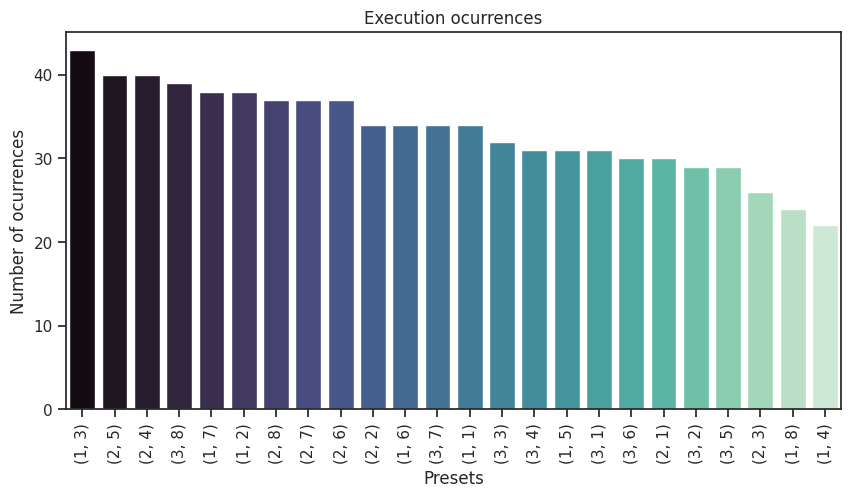

In [86]:
sns.barplot(x = presetdata.Combined.value_counts().index, y = presetdata.Combined.value_counts().values, palette = 'mako')

plt.title('Execution ocurrences')
plt.xticks(rotation=90)
plt.xlabel('Presets')
plt.ylabel('Number of ocurrences')
plt.show()

We can also analyze how these presets behave on failure.

In [87]:
failuredata = data[data['Fail'] == True]
failuredata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 12 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        66 non-null     int64  
 1   Preset_1     66 non-null     int64  
 2   Preset_2     66 non-null     int64  
 3   Temperature  66 non-null     float64
 4   Pressure     66 non-null     float64
 5   VibrationX   66 non-null     float64
 6   VibrationY   66 non-null     float64
 7   VibrationZ   66 non-null     float64
 8   Frequency    66 non-null     float64
 9   Fail         66 non-null     bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 5.2 KB


In [88]:
# Analyzing presets

print("Preset 1:", sorted(failuredata.Preset_1.unique()),"- Preset 2:", sorted(failuredata.Preset_2.unique()))
print("Preset 1 lenght:", len(failuredata.Preset_1.unique()), "- Preset 2 lenght:", len(failuredata.Preset_2.unique()))
print("Total presets combination possibilities:", len(failuredata.Preset_1.unique())*len(failuredata.Preset_2.unique()))

Preset 1: [1, 2, 3] - Preset 2: [1, 2, 3, 4, 5, 6, 7, 8]
Preset 1 lenght: 3 - Preset 2 lenght: 8
Total presets combination possibilities: 24


In [89]:
presetdata = failuredata[['Preset_1', 'Preset_2']].copy()
# print(len(presetdata)) = 800

listadd = []
for index, row in presetdata.iterrows():
  tupleadd = (row['Preset_1'], row['Preset_2'])
  listadd.append(tupleadd)

presetdata['Combined'] = listadd
presetdata.head()

,Preset_1,Preset_2,Combined
12,1,1,"(1, 1)"
156,3,1,"(3, 1)"
157,2,5,"(2, 5)"
158,3,5,"(3, 5)"
162,1,2,"(1, 2)"


In [90]:
presetdata.Combined.value_counts()

(1, 2)    5
(1, 5)    5
(1, 7)    4
(2, 8)    4
(1, 1)    4
(3, 5)    4
(2, 1)    4
(2, 5)    3
(2, 6)    3
(1, 6)    3
(3, 1)    3
(3, 6)    3
(3, 7)    3
(1, 3)    2
(2, 7)    2
(1, 4)    2
(2, 2)    2
(3, 3)    2
(1, 8)    2
(3, 2)    2
(2, 3)    2
(2, 4)    1
(3, 8)    1
Name: Combined, dtype: int64

In [91]:
error = list(presetdata.Combined.value_counts().index)

set_difference = set(full) - set(error)
list(set_difference)

[(3, 4)]

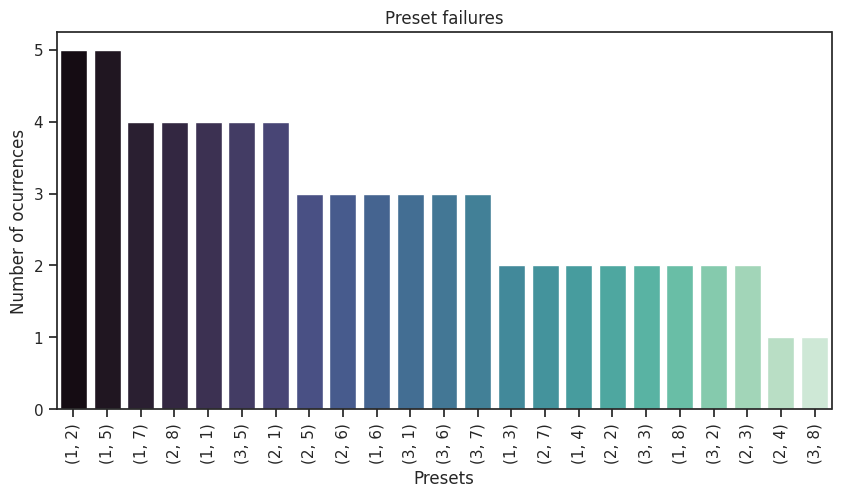

In [92]:
sns.barplot(x = presetdata.Combined.value_counts().index, y = presetdata.Combined.value_counts().values, palette = 'mako')

plt.title('Preset failures')
plt.xticks(rotation=90)
plt.xlabel('Presets')
plt.ylabel('Number of ocurrences')
plt.show()

In the 66 failure occurrences, we have that the most problematic presets (1, 2) and (1, 5) occurred 5 times each, which corresponds to approximately 7% of the occurrences for each one. We can also verify that the faults are distributed asymmetrically among the presets and that of the 24 possible presets, 23 are present in the faults, leaving only the preset (3, 4) out.

---

# Correlating variables

We will plot a heatmap using variable correlation to understand how dataset variables talk to each other and understand how they correlate to failure. Looking again at our dataset:

---



In [93]:
data.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


We can see that the variables *Preset_1* and *Preset_2* are what we call **categorical variables**, that is, they do not imply a quantified value.

* Eg: *Preset_1* at value 2 is not worth twice as much (or twice as efficient) than *Preset_1* at value 1. It makes no sense to order them either.

Therefore, it makes no sense to carry out a correlation study of these variables using the Pearson coefficient, thus, we will create a new dataset excluding these two columns.

Text(0.5, 1.0, 'Correlation Matrix')

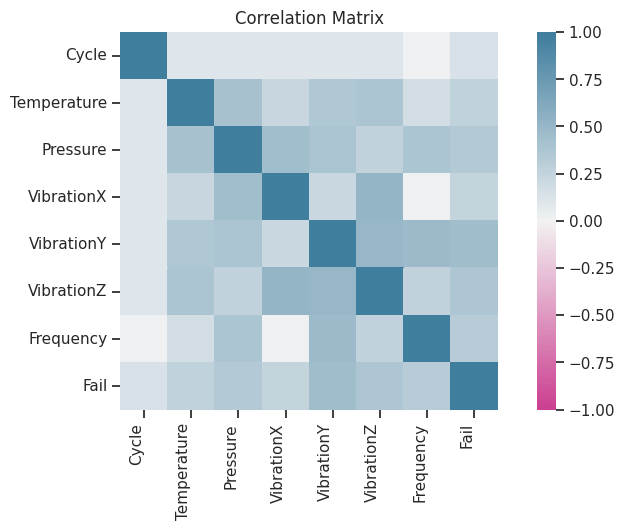

In [94]:
corrdata = data[['Cycle', 'Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail']].copy()
corr = corrdata.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(339, 232, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

plt.title('Correlation Matrix')



Using the corrplot function of R, we were able to use categorical variables in the correlation matrix due to its ease of implementation. The image below shows the correlation matrix made in RStudio.

```
library(readxl)
df=read_excel('D:\_pgms\shape')
library(corrplot)
corrplot(cor(na.omit(df)), method = "number", type="upper")
```



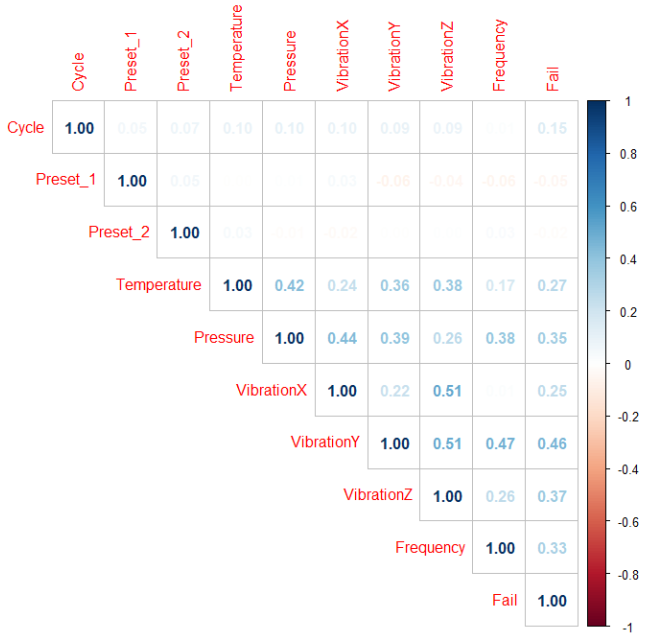

Through these analyses, we can verify that the setups (Preset_1 and Preset_2) do not, in fact, have a significant influence on the failure.

---

# Choosing the model

To model this problem we will use classifiers, more specifically binary classifiers, as they meet the problem output, which is to define if the equipment will work (0), or fail (1). Classifiers can be divided into statistical or structural classifiers. Statistical classifiers are based on probabilities and are ranked by limits. Some of the most common are:

* Logistic Regression.
* Naive-Bayes.
* Support Vector Machines (function-based).

Structural ones are based on rules, distances or neural networks. Some of the most common are:

* Decision Trees.
* Random Forest.
* Support Vector Machines (based on rules).

To define which model is the most interesting for the project, we depend on its metrics. Some metrics used in this project were:

* Confusion matrix.
* Accuracy.
* Precision.
* Recall.
* Score F1.

In addition, we must take into account that our dataset is strongly unbalanced, as the percentage of failures compared to times when the equipment worked as it should is low, less than 10%, and the type of problems we face takes into account operating cycles of equipment, so there is a logical timeline for the data.

## Imports

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

# Logistic Regression
from sklearn.linear_model import LogisticRegression
# Support Vector Machines
from sklearn.svm import LinearSVC
# Decision Trees
from sklearn.tree import DecisionTreeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Variables analysis

Here we will analyze the Temperature, Pressure, VibrationXYZ and Frequency variables in relation to the failure.

In [96]:
vardata = data[['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail']]
vardata.head()

,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [97]:
# separate x and y variables

x = vardata[['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']]
y = vardata[['Fail']]

In [98]:
# making the train_test_split with suffle=False

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, shuffle=False)

In [99]:
# avoid data leak

standardizer = StandardScaler()
scaler = standardizer.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Testing using *DecisionTreeClassifier*

---

In [100]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [101]:
predictions = model.predict(x_test)

In [102]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy = (TP+TN)/(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  16
False Positive(FP) =  10
True Negative(TN)  =  274
False Negative(FN) =  20
Accuracy of the binary classification = 0.906


Feature: 0, Score: 0.17295
Feature: 1, Score: 0.10840
Feature: 2, Score: 0.00879
Feature: 3, Score: 0.23209
Feature: 4, Score: 0.27550
Feature: 5, Score: 0.20226


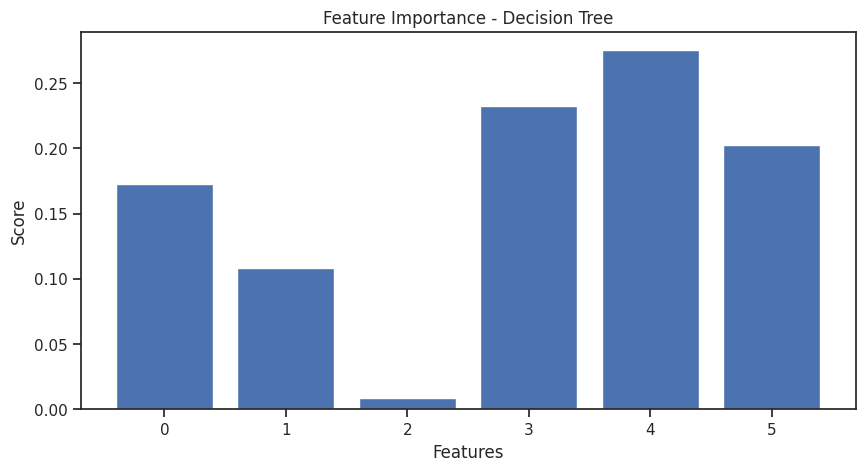

In [103]:
importance = model.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance - Decision Tree')
plt.ylabel('Score')
plt.xlabel('Features')
plt.show()

Comparing the models

---

In [104]:
models = {}

models['Logistic Regression'] = LogisticRegression(random_state = 0, max_iter = 1000)
models['Support Vector Machines'] = LinearSVC(random_state = 0, max_iter = 1000)
models['Decision Trees'] = DecisionTreeClassifier()
models['Random Forest'] = RandomForestClassifier()

accuracy, precision, recall, f1score, fn = {}, {}, {}, {}, {}

for key in models.keys():
    
    # fit the classifier model
    models[key].fit(x_train, y_train.values.ravel())
    
    # prediction 
    predictions = models[key].predict(x_test)

    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
    
    # calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    f1score[key] = f1_score(predictions, y_test)
    fn[key] = FN

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1-Score'] = f1score.values()
df_model['FN'] = fn.values()

df_model

,Accuracy,Precision,Recall,F1-Score,FN
Logistic Regression,0.925000,0.361111,0.928571,0.520000,23
Support Vector Machines,0.921875,0.333333,0.923077,0.489796,24
Decision Trees,0.906250,0.444444,0.615385,0.516129,20
Random Forest,0.915625,0.416667,0.714286,0.526316,21


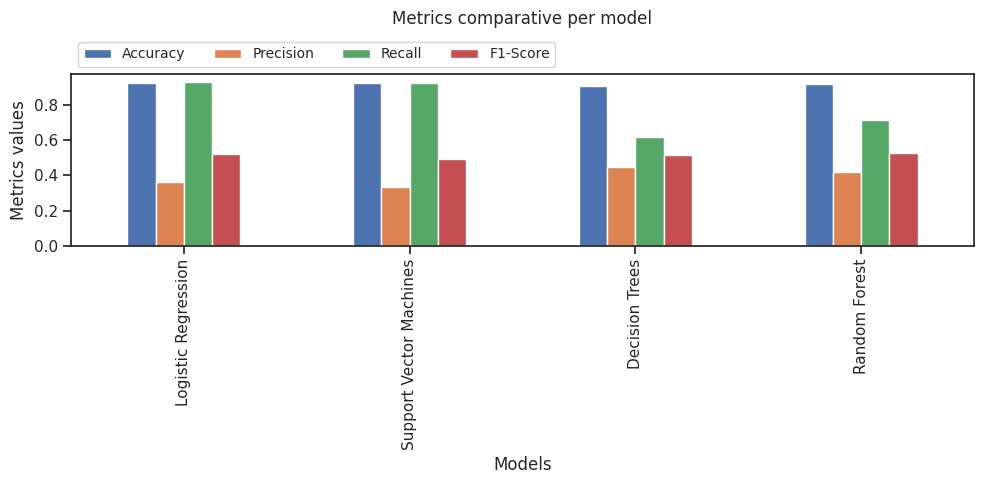

In [105]:
ax  = df_model[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot.bar(rot=90)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.title('Metrics comparative per model\n\n')
plt.xlabel('Models')
plt.ylabel('Metrics values')
plt.tight_layout()

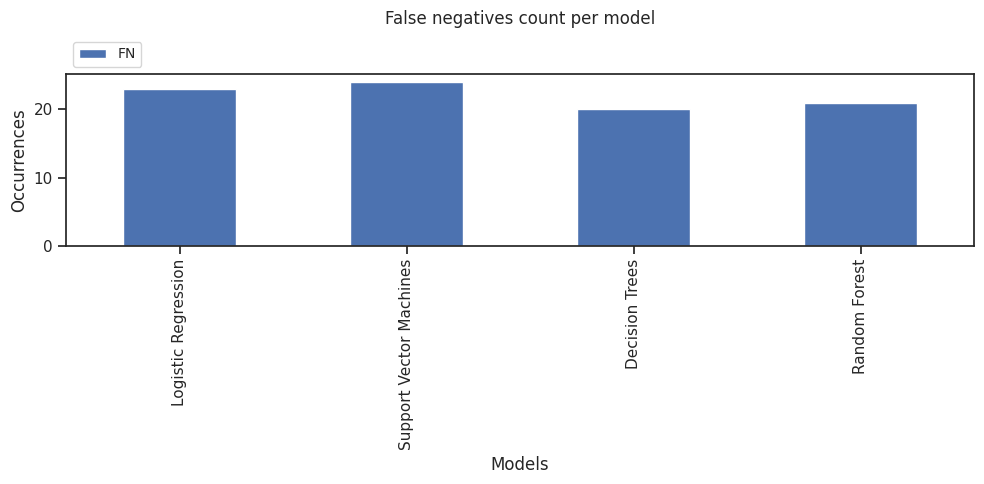

In [106]:
ax  = df_model[['FN']].plot.bar(rot=90)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.title('False negatives count per model\n\n')
plt.xlabel('Models')
plt.ylabel('Occurrences')
plt.tight_layout()

Through the metrics presented above, we can choose the best model to analyze the importance of the variables in relation to failure. 

As already said, the metric that costs more to any company are the false negatives. So, we'll be using them as a form of choosing the best model. For each interaction of the model, we'll have roughtly the same quantity of false negatives, so, we'll perform with **Random Forest**.

---

In [107]:
model = RandomForestClassifier()
model.fit(x_train, y_train.values.ravel())
predictions = model.predict(x_test)

In [108]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy = (TP+TN)/(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  14
False Positive(FP) =  6
True Negative(TN)  =  278
False Negative(FN) =  22
Accuracy of the binary classification = 0.912


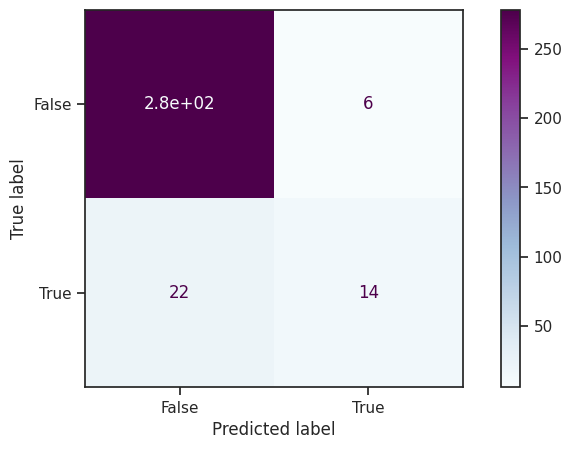

In [134]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, x_test, y_test, cmap='BuPu')
plt.show()

Feature: 0, Score: 0.14586
Feature: 1, Score: 0.10779
Feature: 2, Score: 0.11118
Feature: 3, Score: 0.23711
Feature: 4, Score: 0.23871
Feature: 5, Score: 0.15935


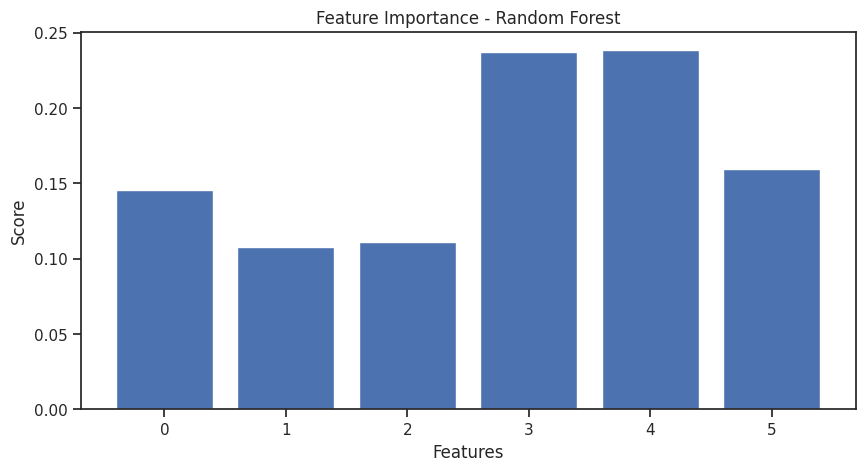

In [109]:
importance = model.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.title('Feature Importance - Random Forest')
plt.ylabel('Score')
plt.xlabel('Features')
plt.show()

We can see that the corresponding variables Feature 3 and Feature 4 are like what has more importance in the model, therefore, more influence. Are they:

* Feature 3: VibrationY (y-axis vibration)
* Feature 4: VibrationZ (z-axis vibration)

We can also see that Feature 5 (frequency) and Feature 0 (temperature) are approximately similar, meaning that they probably have the same importance of the model.

We can't be sure if this data is simulated or true measured data which has physical meaning. But if we assume that the equipment is part of a process line, it makes sense that if the x-axis corresponds to the direction of the process fluid flow, the axes y and z will be vibrations that will cause micro-torsions molds to act on the pipe, which can lead to equipment damage on the long term.

---

If we look for some physical meaning for our equipment analysis problems within an FPSO, several other factors could be introduced in the database, like:

- equipment type: sensors, instrumented valves, control systems, elecrical modules, motors, and others.
- equipment location: on the pipeline, deck, helideck, engine room, and others.
- and more.


Those factores would lead the knowledge in instrumentation, automation and process engineering to complement the data analysis and give a more strong feedback for each type of failure.

---



# Cross validating the model and hyperparameter tuning

When we deal with a Machine Learning problem, we split our data into training and testing sets. Using Cross Validation (CV) most common method, called K-Fold CV, the training data is split into a **K** number of subsets, called folds. The model is fit iteratively **K** times, validating in the **K**-th fold. The [figure below](https://stackoverflow.com/questions/31947183/how-to-implement-walk-forward-testing-in-sklearn) explains each experiment and folding of data.


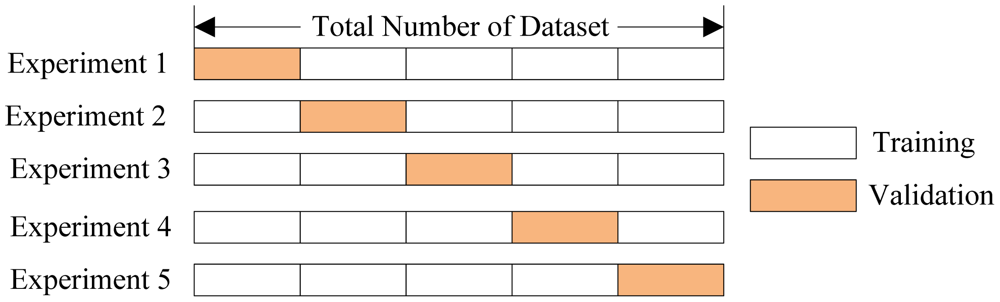

At the end of this training, we can evaluate the data by averaging the performance on each fold, with its metrics for the model.

---

In [110]:
from pprint import pprint

rf = RandomForestClassifier(random_state=42)

# let's take a look at the parameters on our forest
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [111]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
               
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [112]:
rf = RandomForestClassifier()

# cv is the param for cross validating the model
rf_random = RandomizedSearchCV(estimator=rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [113]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 600}

In [114]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(np.subtract(predictions, test_labels, dtype=np.float32))
    mape = 100 * np.mean(errors / len(test_labels))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [115]:
model_accuracy = evaluate(model, x_train, y_train.values)
random_accuracy = evaluate(rf_random.best_estimator_, x_train, y_train.values)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - model_accuracy) / model_accuracy))

Model Performance
Average Error: 0.1172 degrees.
Accuracy = 99.98%.
Model Performance
Average Error: 0.1154 degrees.
Accuracy = 99.98%.
Improvement of 0.00%.


In [116]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [3, 5, 6],
    'n_estimators': [300, 400, 500]
    }

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [117]:
grid_search.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  3.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [118]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 500}

In [119]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_train, y_train.values)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - model_accuracy) / model_accuracy))

Model Performance
Average Error: 0.1117 degrees.
Accuracy = 99.98%.
Improvement of 0.00%.


Tuned (???)


---

# SHAP (**SH**apley **A**dditive ex**P**lanations) implementation


In [120]:
!pip install shap

In [121]:
import shap

explainer = shap.TreeExplainer(model = model)

shap_values_train = explainer.shap_values(x_train, y_train.values)

In [122]:
y_pred_train_proba = model.predict_proba(x_train)

In [123]:
print('Probabilidade do modelo prever \'False\' -',100*y_pred_train_proba[3][0].round(2),'%.')
print('Probabilidade do modelo prever \'True\' -',100*y_pred_train_proba[3][1].round(2),'%.')

Probabilidade do modelo prever 'False' - 81.0 %.
Probabilidade do modelo prever 'True' - 19.0 %.


In [124]:
columns = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
for col, vShap in zip(columns, shap_values_train[1][3]):
    print('###################', col)
    print('Valor SHAP associado:',100*vShap.round(2))
    print('Valor SHAP associado:',100*(100*vShap.round(2)/50).round(2),'%')

################### Temperature
Valor SHAP associado: 2.0
Valor SHAP associado: 4.0 %
################### Pressure
Valor SHAP associado: 1.0
Valor SHAP associado: 2.0 %
################### VibrationX
Valor SHAP associado: 2.0
Valor SHAP associado: 4.0 %
################### VibrationY
Valor SHAP associado: 4.0
Valor SHAP associado: 8.0 %
################### VibrationZ
Valor SHAP associado: 11.0
Valor SHAP associado: 22.0 %
################### Frequency
Valor SHAP associado: -7.000000000000001
Valor SHAP associado: -14.000000000000002 %


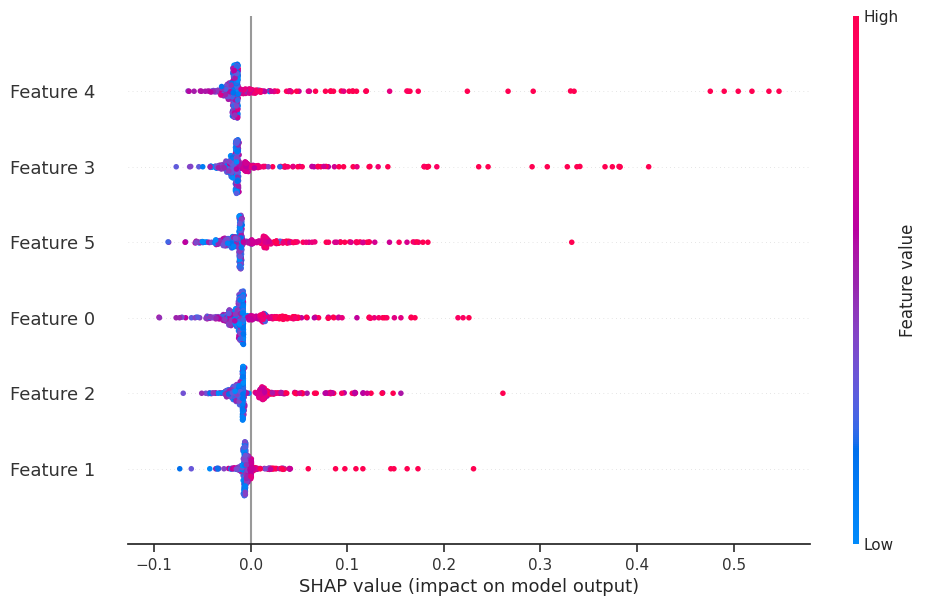

In [125]:
shap.summary_plot(shap_values_train[1], x_train, plot_type="dot", plot_size=(11,7));

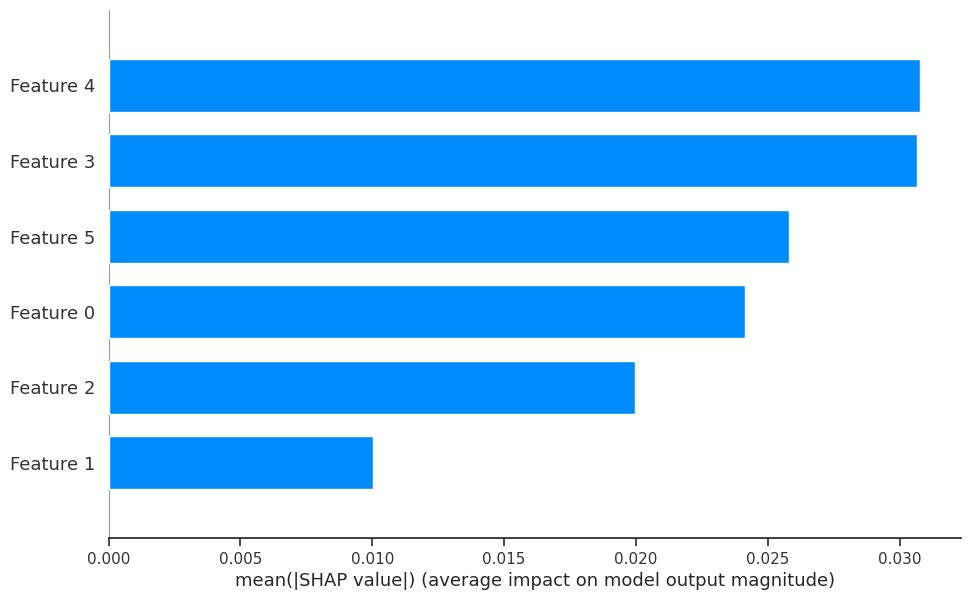

In [126]:
shap.summary_plot(shap_values_train[1], x_train, plot_type="bar", plot_size=(11,7));

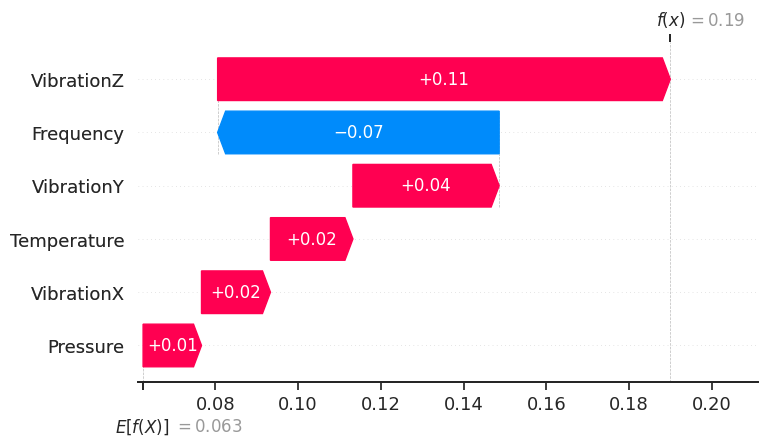

In [127]:
expected_value = explainer.expected_value
shap.plots._waterfall.waterfall_legacy(expected_value=expected_value[1], shap_values=shap_values_train[1][3].reshape(-1), feature_names=columns, show=True)

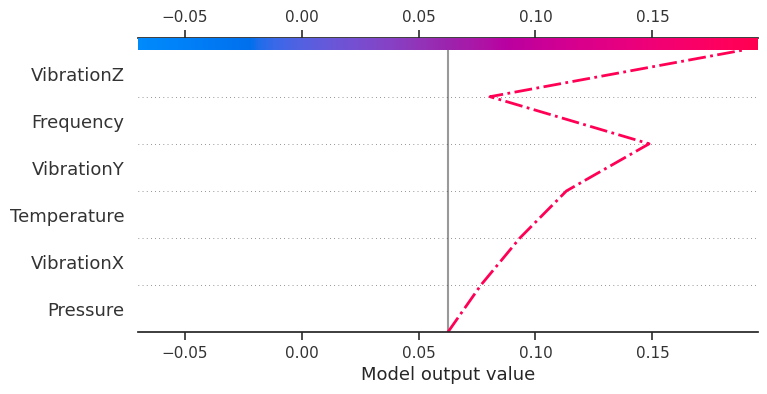

In [128]:
shap.decision_plot(base_value=expected_value[1], shap_values=shap_values_train[1][3], features=columns,highlight=0)

# Conclusion

We made a general analysis of the dataset and created a simple random forest model to predict failure. We also discussed during the document a lot of questions regarding the data on the dataset. 

Knowing the problems on the data, other approaches to this problem would be possible, but due to the delivery date, they were not implemented.

- We could oversample the data using Smote.
- We could use other models such as XGBoost or Catboost.
- We could tune the hyperparameters of the model trained using Gridsearch, and
- We could use a better approach to explain the output of the model using SHAP.